<h1><center>Predicting Default Payment by Using Various Machine Learning Algorithm and Skills of Data Analysis</center></h1>
<h3><center> Hao Li </center></h3>
<h4><center> March 04 2022 </center></h4>

<h2>1. Introduction </h2>
<blockquote><font color=SlateGray>Probability of Default is the risk that the borrower will be unable or unwilling to repay its debt in full or on time. The risk of default is derived by analyzing the obligor's capacity to repay the debt in accordance with contractual terms.
    <center>— [Office of the Comptroller of the Currency]</center></font>
</blockquote>

Our client has brought us a dataset that includes some demographics
and recent financial data, over the past 6 months, for a sample of 30,000 of their account holders. Traditionally, default probabilities may be estimated from a historical database of actual defaults using modern techniques like *logistic regression*. 

Our task here is to select one or more ML models and feed them the historical data. Then we will tune the models and make them capture the features, and make predictions by themselves.

<h2>2. Data Preparation </h2>

<h3><font color=DarkSlateBlue>2.01 Library Import: </font></h3>

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif, chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB,ComplementNB,MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

<div class="alert alert-block alert-success">
Here is a quick recall of what we have done to our dataset in the past 2 parts of our project.
</div>


 * [x] Removing 313 duplicated IDs
 * [x] Removing 315 rows with all zero features
 * [x] Removing 3021 rows that contained not-available in ```PAY_1``` feature
 * [x] Replacing odd values with the right ones in ```EDUCATION``` and ```MARRIAGE``` features
 * [x] Implementing One-Hot Encoding for the ```EDUCATION``` feature
 
After making these processes, our cleaned dataset looks like below:

In [2]:
df = pd.read_csv('cleaned_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26664 entries, 0 to 26663
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          26664 non-null  object
 1   LIMIT_BAL                   26664 non-null  int64 
 2   SEX                         26664 non-null  int64 
 3   EDUCATION                   26664 non-null  int64 
 4   MARRIAGE                    26664 non-null  int64 
 5   AGE                         26664 non-null  int64 
 6   PAY_1                       26664 non-null  int64 
 7   PAY_2                       26664 non-null  int64 
 8   PAY_3                       26664 non-null  int64 
 9   PAY_4                       26664 non-null  int64 
 10  PAY_5                       26664 non-null  int64 
 11  PAY_6                       26664 non-null  int64 
 12  BILL_AMT1                   26664 non-null  int64 
 13  BILL_AMT2                   26664 non-null  in

Currently, we have 26664 users' information and there are 30 features correspond to each user. Notice that the last 4 features are the one-hot encoding of ```EDUCATION``` which is the same thing as ```EDUCATION_CAT```. Hence, to make it clear, we remove the last 5 columns plus the ```ID``` feature (tells us nothing) which will leave us the rest 13 features.

In [3]:
Non_features = ['ID','EDUCATION_CAT','graduate school','high school','others','university']
df_0 = df.drop(columns=Non_features).copy()
print(df_0.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26664 entries, 0 to 26663
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   26664 non-null  int64
 1   SEX                         26664 non-null  int64
 2   EDUCATION                   26664 non-null  int64
 3   MARRIAGE                    26664 non-null  int64
 4   AGE                         26664 non-null  int64
 5   PAY_1                       26664 non-null  int64
 6   PAY_2                       26664 non-null  int64
 7   PAY_3                       26664 non-null  int64
 8   PAY_4                       26664 non-null  int64
 9   PAY_5                       26664 non-null  int64
 10  PAY_6                       26664 non-null  int64
 11  BILL_AMT1                   26664 non-null  int64
 12  BILL_AMT2                   26664 non-null  int64
 13  BILL_AMT3                   26664 non-null  int64
 14  BILL_A

In the next section, we will investigate the data by using some statistical analysis to find the significance of the variables so that we can remove the insignificant data that might mess up the accuracy of the algorithms later.

<h2>3. Data Analysis </h2>

<h3><font color=DarkSlateBlue>3.01 F-test: </font></h3>

ANOVA uses F-test check if there is any significant difference between the groups. *Sklearn* has provided us the function: ```f_classif```.

In [4]:
X_f = df_0.iloc[:,0:23].values
Y_f = df_0.iloc[:,23].values

y_f = f_classif(X_f, Y_f)[0]
x_f = range(23)

y_p = f_classif(X_f, Y_f)[1]
x_p = range(23)

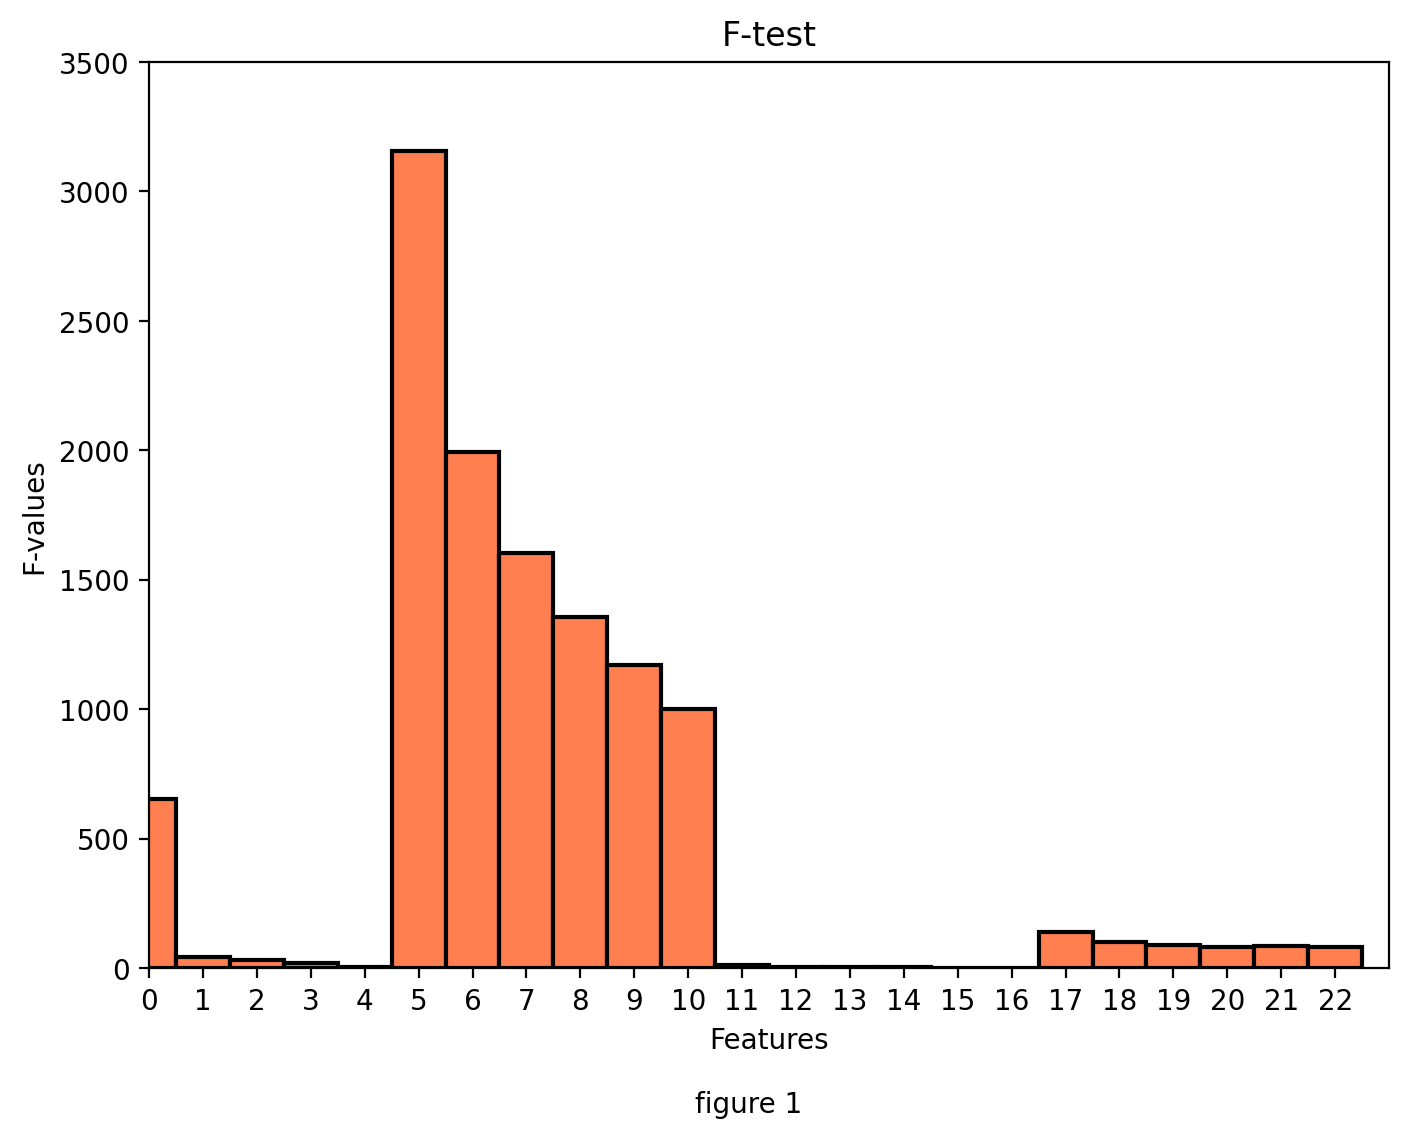

In [5]:
txt="figure 1"

fig, ax = plt.subplots(figsize=(8, 6),dpi =200)

ax.bar(x_f, y_f, width=1,color = 'Coral', edgecolor="black", linewidth=1.5)
ax.set(xlim=(0, 23), xticks=np.arange(0, 23),
       ylim=(0, 3500))

plt.title("F-test")
plt.xlabel("Features")
plt.ylabel("F-values")
fig.text(.5, .005, txt, ha='center')

plt.show()

<h3><font color=DarkSlateBlue>3.02 Chi-squared test: </font></h3>

A chi-square statistic is another way to show a relationship between two variables. *Sklearn* also provides us the function: ```chi2```. Note that ```chi2``` only deals with non-negative features.

In [6]:
X_chi = df_0.drop(columns=['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3',
                           'BILL_AMT4','BILL_AMT5','BILL_AMT6','default payment next month']).values
Y_chi = df_0.iloc[:,23].values

y_chi = chi2(X_chi, Y_chi)[0]
x_chi = ['0','1','2','3','4','17','18','19','20','21','22']

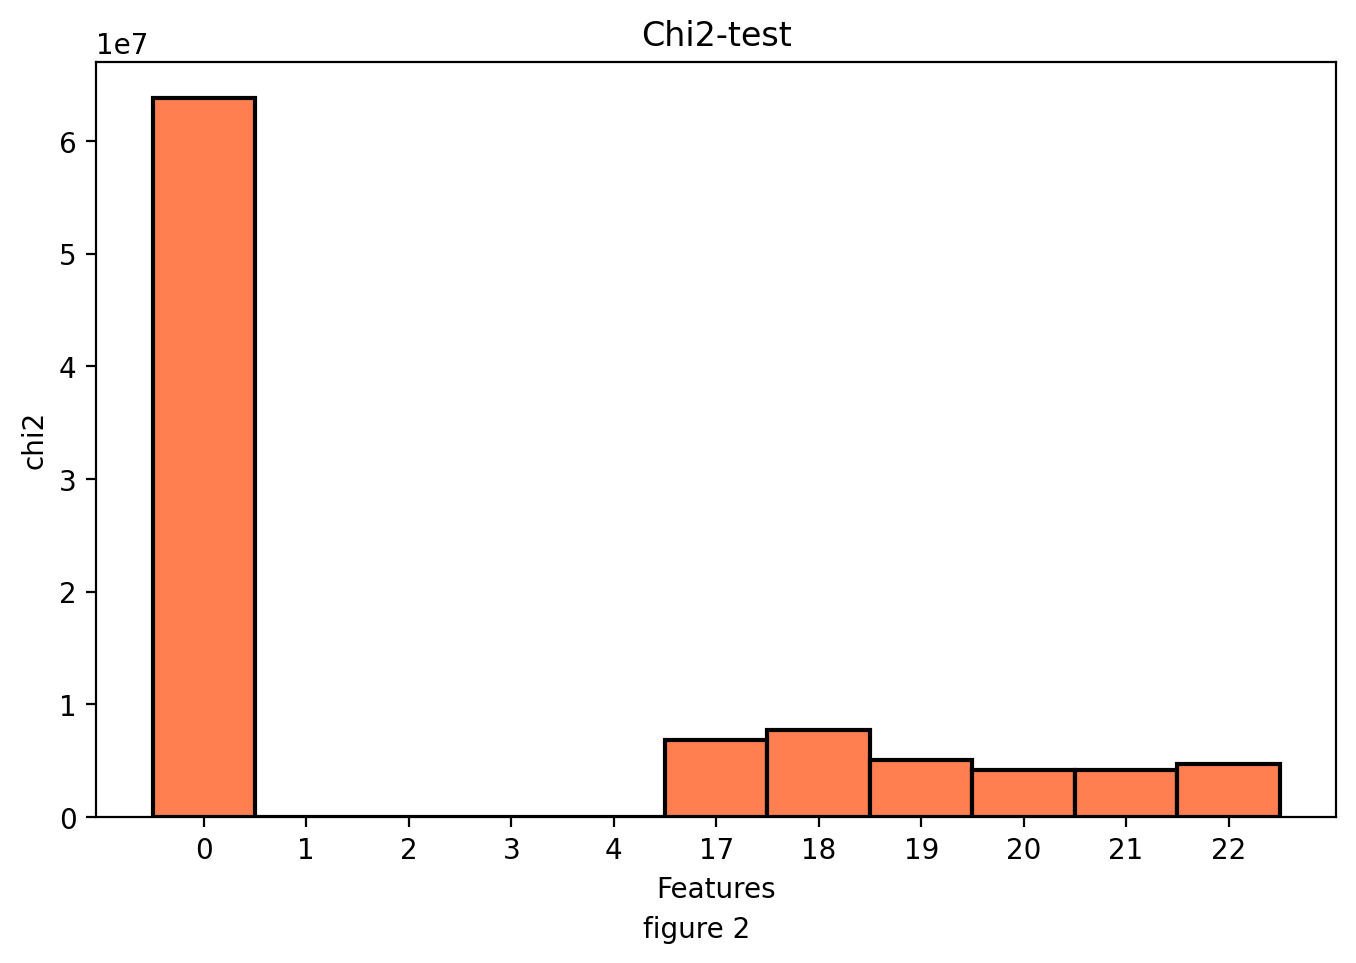

In [7]:
txt1 = 'figure 2'

fig, ax = plt.subplots(figsize=(8, 5),dpi =200)

ax.bar(x_chi, y_chi, width=1,color = 'Coral', edgecolor="black", linewidth=1.5)

plt.title("Chi2-test")
plt.xlabel("Features")
plt.ylabel("chi2")
fig.text(.5, .005, txt1, ha='center')

plt.show()

<h3><font color=DarkSlateBlue>3.03 Summary: </font></h3>

The F-value in an ANOVA is calculated as: variation between sample means / variation within the samples. In short words, the higher the F-value is, the better a feature is to discriminate between two classes. Hence, in figure 1, we can say feature 0, 5-10, and 17-22 are the more significant features. Moreover, by using the Chi-squared test, figure 2 approved that we should reject feature 1-4.

After dropping those non-significant features, it leaves us the rest 13 features:

In [8]:
Non_features = ['SEX','EDUCATION','MARRIAGE','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3',
                'BILL_AMT4','BILL_AMT5','BILL_AMT6']
df_1 = df_0.drop(columns=Non_features).copy()
print(df_1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26664 entries, 0 to 26663
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   26664 non-null  int64
 1   PAY_1                       26664 non-null  int64
 2   PAY_2                       26664 non-null  int64
 3   PAY_3                       26664 non-null  int64
 4   PAY_4                       26664 non-null  int64
 5   PAY_5                       26664 non-null  int64
 6   PAY_6                       26664 non-null  int64
 7   PAY_AMT1                    26664 non-null  int64
 8   PAY_AMT2                    26664 non-null  int64
 9   PAY_AMT3                    26664 non-null  int64
 10  PAY_AMT4                    26664 non-null  int64
 11  PAY_AMT5                    26664 non-null  int64
 12  PAY_AMT6                    26664 non-null  int64
 13  default payment next month  26664 non-null  int64
dtypes: int

<h3><font color=DarkSlateBlue>3.04 Data Scaling and Split: </font></h3>

There are three choices of Scalers on *Sklearn*: StandardScaler, MinMaxScaler, and RobustScaler. If we make a quick histogram of our features, we will see all the data are skewed. Because StandardScaler presumes that the data are normally distributed and MinMaxScalar gets influenced heavily by outliers, the best choice for us will be the RobustScaler where the scaler removes the median and scales the data according to the quantile range (default from 25.0 - 75.0).

In [9]:
X = df_1.iloc[:,0:13].values
Y = df_1.iloc[:,13].values

from sklearn.preprocessing import RobustScaler
scale = RobustScaler(quantile_range=(25.0, 75.0))

X_scale = scale.fit_transform(X)
Y_scale = Y.ravel()

print(X_scale.shape,Y_scale.shape)

(26664, 13) (26664,)


Then we split our data by the default ratio: 0.2.

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scale, Y_scale, test_size=0.2, random_state=42)

Here we end our data analysis and in the next section, we will choose the appropriate models to train them to get the first sight of our results.

<h2>4. Model Selection and Training </h2>

<h3><font color=DarkSlateBlue>4.01 Model Selection:</font></h3>

There are five classification models we have learned so far:
- [x]  Naïve Bayes
- [x] <font color=DarkGreen> Support Vector Machine</font>
- [x] <font color=DarkGreen> Random Forest</font>
- [x] <font color=DarkGreen> Logistic Regression</font>
- [x] <font color=DarkGreen> Neural Networks</font>

In ProjetcPart2, we have tried Naïve Bayes and SVM two models. In Naïve Bayes we got 78.6% accuracy but unfortunately, in SVM because the model was too sensitive, it didn't catch any default cases. So, we are going to try SVM again and this time we have four models which are: SVM, Random Forest(RF), Logistic Regression(LR), and Neural Networks(NN).

<h3><font color=DarkSlateBlue>4.02 Model Training: </font></h3>

<div class="alert alert-block alert-success">
In this section, I will just include SVM, Random Forest, and Logistic Regression models. For Neural Networks, I will put it into section 6. I will begin all three models by its default parameters and in the next section, I will tune the parameters to get the best results.
</div>

<h4><font color=navy>SVM Model: </font></h4>

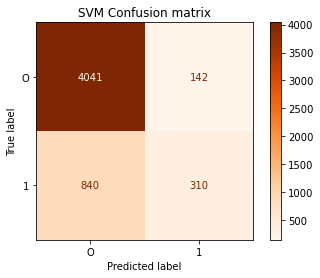

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      4183
           1       0.69      0.27      0.39      1150

    accuracy                           0.82      5333
   macro avg       0.76      0.62      0.64      5333
weighted avg       0.80      0.82      0.78      5333



In [11]:
clf_SVM = SVC(random_state=42)
clf_SVM = clf_SVM.fit(X_train,Y_train)
predictions_SVM = clf_SVM.predict(X_test)
disp = ConfusionMatrixDisplay.from_estimator(clf_SVM, X_test, Y_test, display_labels=['O','1'],
                                             cmap=plt.cm.Oranges,normalize=None)
disp.ax_.set_title("SVM Confusion matrix")

plt.show()
print(classification_report(Y_test,predictions_SVM))

<h4><font color=navy>Random Forest Model: </font></h4>

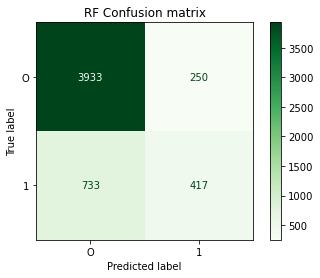

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4183
           1       0.63      0.36      0.46      1150

    accuracy                           0.82      5333
   macro avg       0.73      0.65      0.67      5333
weighted avg       0.80      0.82      0.80      5333



In [12]:
clf_RF = RandomForestClassifier(random_state=42)
clf_RF = clf_RF.fit(X_train,Y_train)
predictions_RF = clf_RF.predict(X_test)
disp = ConfusionMatrixDisplay.from_estimator(clf_RF, X_test, Y_test, display_labels=['O','1'],
                                             cmap=plt.cm.Greens,normalize=None)
disp.ax_.set_title("RF Confusion matrix")

plt.show()
print(classification_report(Y_test,predictions_RF))

<h4><font color=navy>Logistic Regression: </font></h4>

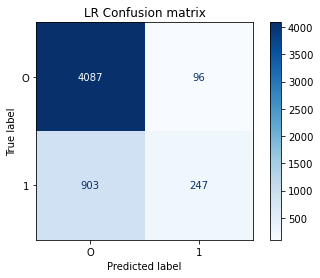

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      4183
           1       0.72      0.21      0.33      1150

    accuracy                           0.81      5333
   macro avg       0.77      0.60      0.61      5333
weighted avg       0.80      0.81      0.77      5333



In [13]:
clf_LR = LogisticRegression(random_state=42)
clf_LR = clf_LR.fit(X_train,Y_train)
predictions_LR = clf_LR.predict(X_test)
disp = ConfusionMatrixDisplay.from_estimator(clf_LR, X_test, Y_test, display_labels=['O','1'],
                                             cmap=plt.cm.Blues,normalize=None)
disp.ax_.set_title("LR Confusion matrix")

plt.show()
print(classification_report(Y_test,predictions_LR))

This is the first slight of our results. Before tuning the parameters, we have seen that we got around 2-3% accuracy improvements. Especially for the SVM model, after cleaning the data again, it can catch some default cases for this time now. Among these three models, Random Forest has the highest accuracy 82%,  and the best f1-score so far. However, in general, all these three models are bad at catching default cases. The highest recall is only 36%.

<h2>5. Model Tuning </h2>

In this section, we will use ```GridSearchCV``` from ```sklearn.model_selection``` to find the best parameters. More specifically, we are looking for the model that gave us the highest recall score. This is because in predicting the default payment, we don't want too much type II error which is predicting the case to be non-default but in reality it's default. 

Recall score answers how many default cases you can find among all actual default cases. In short words, it tells the ability to catch default cases and that is what we are looking for. So the metric of our search will be recall.

<h3><font color=DarkSlateBlue>5.01 Model Selection:</font></h3>

<h4><font color=navy>Best SVM Model: </font></h4>

In [13]:
parameters = {'C': [0.1, 1, 10],
              'gamma':['scale','auto'],
              'kernel': ['rbf', 'sigmoid'],
             'class_weight': ['balanced',None]}

In [14]:
SVM_clf = SVC(random_state=42)
SVM_clf = GridSearchCV(SVM_clf, param_grid=parameters, scoring='recall', n_jobs = -1, cv = 5)
SVM_clf = SVM_clf.fit(X_train,Y_train)
print('The best SVM model:\n', SVM_clf.best_params_)

The best SVM model:
 {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'sigmoid'}


<div class="alert alert-block alert-danger">
<b>Note:</b> For SVM model, I didn't try 'linear' or 'ploy' kernel because they just took an unreasonable long time (over 2 hours) to process.
</div>

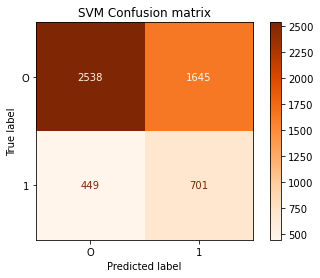

              precision    recall  f1-score   support

           0       0.85      0.61      0.71      4183
           1       0.30      0.61      0.40      1150

    accuracy                           0.61      5333
   macro avg       0.57      0.61      0.55      5333
weighted avg       0.73      0.61      0.64      5333



In [15]:
SVM_clf_best = SVM_clf.best_estimator_

predictions_SVM_best =SVM_clf_best.predict(X_test)
disp = ConfusionMatrixDisplay.from_estimator(SVM_clf_best, X_test, Y_test, display_labels=['O','1'],
                                             cmap=plt.cm.Oranges,normalize=None)
disp.ax_.set_title("SVM Confusion matrix")

plt.show()
print(classification_report(Y_test,predictions_SVM_best))

<h4><font color=navy>Best Random Forest Model: </font></h4>

In [16]:
parameters = {'n_estimators': [100, 200],
              'criterion': ["gini", "entropy"],
              'max_features': ['auto',1, 3, 5],
              'bootstrap': [True, False],
              'class_weight': ['balanced', None]
              }

In [17]:
RF_clf = RandomForestClassifier(random_state=42)
RF_clf = GridSearchCV(RF_clf, param_grid=parameters, scoring='recall', n_jobs = -1, cv = 5)
RF_clf = RF_clf.fit(X_train,Y_train)
print('The best Random Forest model:\n', RF_clf.best_params_)

The best Random Forest model:
 {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 200}


<div class="alert alert-block alert-danger">
<b>Note:</b> For Random Forest model, in order to limit the running in a reasonable range, I only chose five parameters to tune. 
</div>

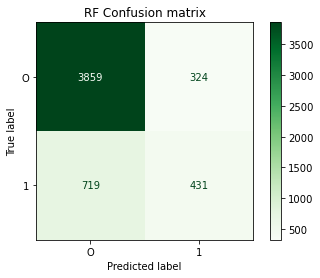

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      4183
           1       0.57      0.37      0.45      1150

    accuracy                           0.80      5333
   macro avg       0.71      0.65      0.67      5333
weighted avg       0.78      0.80      0.79      5333



In [18]:
RF_clf_best = RF_clf.best_estimator_

predictions_RF_best =RF_clf_best.predict(X_test)
disp = ConfusionMatrixDisplay.from_estimator(RF_clf_best, X_test, Y_test, display_labels=['O','1'],
                                             cmap=plt.cm.Greens,normalize=None)
disp.ax_.set_title("RF Confusion matrix")

plt.show()
print(classification_report(Y_test,predictions_RF_best))

<h4><font color=navy>Best Logistic Regression: </font></h4>

In [535]:
parameters = {'C': [0.01, 0.1, 1, 10],
              'fit_intercept': [False,True],
              'class_weight': [None,'balanced'],
              'max_iter': [50, 100,200]}

In [536]:
LR_clf = LogisticRegression(random_state=42)
LR_clf = GridSearchCV(LR_clf, param_grid=parameters, scoring='recall', n_jobs = -1, cv = 5)
LR_clf = LR_clf.fit(X_train,Y_train)
print('The best Logistic Regression model:\n', LR_clf.best_params_)

The best Logistic Regression model:
 {'C': 1, 'class_weight': 'balanced', 'fit_intercept': False, 'max_iter': 50}


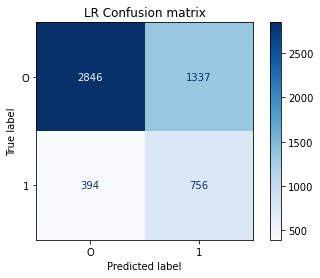

              precision    recall  f1-score   support

           0       0.88      0.68      0.77      4183
           1       0.36      0.66      0.47      1150

    accuracy                           0.68      5333
   macro avg       0.62      0.67      0.62      5333
weighted avg       0.77      0.68      0.70      5333



In [537]:
LR_clf_best = LR_clf.best_estimator_

predictions_LR_best =LR_clf_best.predict(X_test)
disp = ConfusionMatrixDisplay.from_estimator(LR_clf_best, X_test, Y_test, display_labels=['O','1'],
                                             cmap=plt.cm.Blues,normalize=None)
disp.ax_.set_title("LR Confusion matrix")

plt.show()
print(classification_report(Y_test,predictions_LR_best))

<h3><font color=DarkSlateBlue>5.02 Summary:</font></h3>

It's not hard to see, once we switch the metric to recall, we did increase a lot of recall in all three models by sacrificing some overall accuracy.

The Random Forest model is quite stubborn. After tunning it, the model still performe badly at catching the right default cases (the lowest positive recall score: 0.37) even it has the highest overall accuracy.

Among all three models, Logistic Regression keeps a good balance where we have a 0.66 recall score, 0.47 f1 score and overall 0.68 accuracy. 

Next, we will average the three models by majority voting to see if we can find an even better-balanced point.

<h3><font color=DarkSlateBlue>5.03 Model Voting:</font></h3>

In [36]:
clf_SVC_best = SVC(C=0.1, random_state=42,kernel = 'sigmoid',gamma ='scale',class_weight='balanced')
clf_RF_best = RandomForestClassifier(n_estimators=200,bootstrap = False,criterion= 'entropy',class_weight ='balanced', max_features = 'auto')
clf_LR_best = LogisticRegression(random_state=42,C=1,max_iter = 100,class_weight='balanced',fit_intercept=False)

clf_best = VotingClassifier(estimators=[('lr', clf_LR_best), ('rf', clf_RF_best), ('svm', clf_SVC_best)], voting='hard')
clf_best = clf_best.fit(X_train,Y_train)

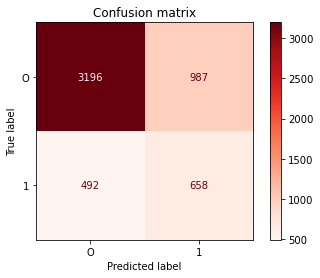

              precision    recall  f1-score   support

           0       0.87      0.76      0.81      4183
           1       0.40      0.57      0.47      1150

    accuracy                           0.72      5333
   macro avg       0.63      0.67      0.64      5333
weighted avg       0.77      0.72      0.74      5333



In [37]:
predictions_best =clf_best.predict(X_test)
disp = ConfusionMatrixDisplay.from_estimator(clf_best, X_test, Y_test, display_labels=['O','1'],
                                             cmap=plt.cm.Reds,normalize=None)
disp.ax_.set_title("Confusion matrix")

plt.show()
print(classification_report(Y_test,predictions_best))

After averaging three models, we got a better accuracy and still kept an around 60% recall score and 47% f1 score. In the next section, I will bring out our last two models, Naive Bayes and Neural Networks to do a model comparison.

<h2>6. Model Comparing </h2>

<h3><font color=DarkSlateBlue>6.01 Naive Bayes:</font></h3>

In [486]:
parameters = {'alpha': [0.1,0.5,1.0],
              'binarize': [0.0,0.5,1.0,1.5, None],
              'fit_prior': [True, False]}

In [487]:
clf_NB = BernoulliNB()
clf_NB = GridSearchCV(clf_NB, param_grid=parameters, scoring='recall', n_jobs = -1, cv = 5)
clf_NB = clf_NB.fit(X_train,Y_train)
print('The best Naive Bayes model:\n', clf_NB.best_params_)

The best Naive Bayes model:
 {'alpha': 0.1, 'binarize': 0.5, 'fit_prior': False}


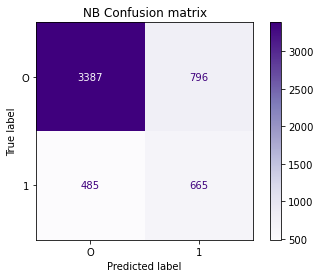

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      4183
           1       0.46      0.58      0.51      1150

    accuracy                           0.76      5333
   macro avg       0.66      0.69      0.68      5333
weighted avg       0.78      0.76      0.77      5333



In [488]:
NB_clf_best = clf_NB.best_estimator_

predictions_NB_best =NB_clf_best.predict(X_test)
disp = ConfusionMatrixDisplay.from_estimator(NB_clf_best, X_test, Y_test, display_labels=['O','1'],
                                             cmap=plt.cm.Purples,normalize=None)
disp.ax_.set_title("NB Confusion matrix")

plt.show()
print(classification_report(Y_test,predictions_NB_best))

<h3><font color=DarkSlateBlue>6.02 Neural Networks:</font></h3>

In [20]:
parameters = {'hidden_layer_sizes': [(100,), (32, 16), (100, 50)],
              'activation': ['logistic', 'tanh', 'relu'],
              'alpha': [0.01,0.001,0.0001],
              'solver': ['adam', 'lbfgs','sgd']}

In [21]:
NN_clf = MLPClassifier(random_state=42)
NN_clf = GridSearchCV(NN_clf, param_grid=parameters, scoring='recall', n_jobs = -1, cv = 5)
NN_clf = NN_clf.fit(X_train,Y_train)
print('The best Logistic Regression model:\n', NN_clf.best_params_)

The best Logistic Regression model:
 {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'solver': 'adam'}


C:\Users\Henry\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


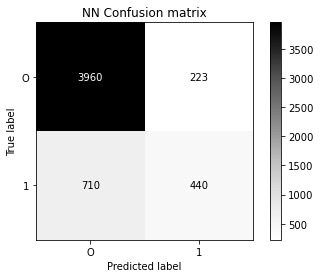

              precision    recall  f1-score   support

           0       0.85      0.95      0.89      4183
           1       0.66      0.38      0.49      1150

    accuracy                           0.83      5333
   macro avg       0.76      0.66      0.69      5333
weighted avg       0.81      0.83      0.81      5333



In [22]:
NN_clf_best = NN_clf.best_estimator_

predictions_NN_best =NN_clf_best.predict(X_test)
disp = ConfusionMatrixDisplay.from_estimator(NN_clf_best, X_test, Y_test, display_labels=['O','1'],
                                             cmap=plt.cm.Greys,normalize=None)
disp.ax_.set_title("NN Confusion matrix")

plt.show()
print(classification_report(Y_test,predictions_NN_best))

<h3><font color=DarkSlateBlue>6.03 Summary:</font></h3>

Naive Bayes model gave us a very balanced point where the recall is around 60% and overall accuracy is 76%. That means among all default customers, we can correctly find 60% of them in advance. For all the customers, 76% of their next payment can be correctly predicted. 

For the Neural Network model, it gave us the highest overall accuracy. That means for all the customers, 83% of their next payment can be correctly predicted. However, for all default customers, we will let 60% of them go in the next month.

<h2>7. Conclusion </h2>

A quick summary of our models:
    
- [x]  Naïve Bayes - <font color=DarkGreen>The most balanced model with the highest f1 score</font>
- [x]  Logistic Regression - <font color=DarkGreen>The highest recall score in default cases</font>
- [x]  Neural Networks - <font color=DarkGreen>The highest overall accuracy and the highest recall score in non-default cases</font>

Hence there are three models left for the company to choose and it's all about how the company values its money. What I mean is some companies may care more about will they catch the default customers or not in the next month but some companies care about their overall reputation. 

More specifically, for small loan companies, if they have limited liquidity, I would suggest they use the **Logistic Regression** model. Because in order to reduce any possible capital loss, they want to catch as many default cases as possible, even some non-default customers might get caught. So for small loan companies, it might be necessary to reduce the capital loss by sacrificing some customer satisfaction.

Some big loan companies are more worried about their customer satisfaction. The time for them to ask for payment of debt is enough to make counterbalanced money. Hence, I would suggest they use the **Neural Networks** model to increase customer satisfaction. In a long term, with more loyal customers, fewer default cases will happen.

Of course, we don't have to go that extreme. Using the **Naïve Bayes** model will give companies the most balanced point. It will catch enough default customers while maintaining good customer satisfaction.